Code for **"Inpainting"** figures $6$, $8$ and 7 (top) from the main paper. 

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

In [2]:
!pip install torch==0.4.1.post2 torchvision==0.2.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/deep-image-prior-master"
os.chdir(path)
os.listdir(path)
sys.path.append('/content/drive/MyDrive/deep-image-prior-master')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libs

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
import imageio 
import os 
import math
import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import torch
import torch.optim
%matplotlib inline
from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

# Choose figure

In [5]:
labda = 0.9
imgname='original11'
img_path  = 'data/dataset/'+imgname+'.jpg'
mask_path = 'data/dataset/mask.jpg'
interationCut= False
NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

# Load mask

In [6]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

### Center crop

In [7]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

### Visualize

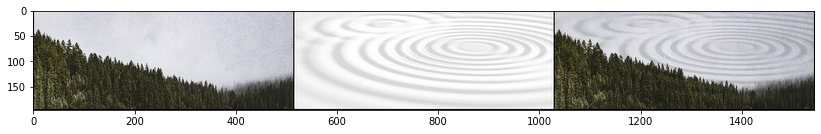

In [8]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);
img_w_mask = img_mask_np*img_np

# Setup

In [9]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'
exp_weight=0.99

In [10]:
INPUT = 'noise'
input_depth = 32
LR = 0.01 
num_iter = 3001
param_noise = False
show_every = 10
figsize = 5
reg_noise_std = 0.03
    
net = skip(input_depth, img_np.shape[0], num_channels_down = [128] * 5,
           num_channels_up =   [128] * 5,
           num_channels_skip =    [128] * 5,  
           filter_size_up = 3, filter_size_down = 3, 
           upsample_mode='nearest', filter_skip_size=1,
           need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [11]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 3002627


# Main loop

In [12]:
i = 0
losspre=0
loss_abs=0
thresold=0
lossabs=[]
losslist = []
psnr_gtlist = []
outlist=[]

def calculateTV(y):
    c,w,h = y.shape
    sum_TV = 0
    for i in range(c):
        sum_cTV = 0
        # each channel we do
        for j in range(w-1):
            for k in range(h-1):
                v = math.pow(y[i,j+1,k]-y[i,j,k],2)
                v = v + math.pow(y[i,j,k+1]-y[i,j,k],2)
                v = math.sqrt(v)
                sum_cTV = sum_cTV + v
        sum_TV = sum_TV + sum_cTV
    return sum_TV



def closure():
    
    global i,labda,outpre,outafter,losspre,thresold,loss_abs
    global losslist,psnr_gtlist,lossabs,outlist
    out_avg = None
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
    
    out = net(net_input)
    out_np = torch_to_np(out)
    
    # //////////////////////////////////
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
    # //////////////////////////////////
    
    total_loss = mse(out * mask_var, img_var * mask_var) + labda * calculateTV(out_np)    
    total_loss.backward()
    
    psnr_gt = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 


    loss_abs=abs(total_loss.item()-losspre)
    losspre=total_loss.item()
    lossabs.append(loss_abs)
    losslist.append(total_loss.item())
    psnr_gtlist.append(psnr_gt)
    outlist.append(torch_to_np(out))
    
    if PLOT and i % show_every == 0:
        #out_np = torch_to_np(out)
        #plot_image_grid([np.clip(out_np, 0, 1),img_mask_np*img_np], factor=figsize, nrow=3)
        #print ('Iteration %05d    Loss %f   PSNR_gt: %f ' % (i, total_loss.item(), psnr_gt))
        img_savepath='loss_result/lamda'+str(labda)+'/'+imgname+'/fig/'
        if not os.path.exists(img_savepath):
          os.makedirs(img_savepath) 
        out_save = out_np.transpose(1, 2, 0)
        imageio.imsave(img_savepath+str(i)+'.png', out_save)


    if i<10:
      max_value=max(losslist)
      min_value=min(losslist)
      thresold=0.4*abs(max_value-min_value)
    if i>=10:
      max_value=max(losslist[:10])
      min_value=min(losslist[:10])
      thresold=0.4*abs(max_value-min_value)
      #print(i,thresold,loss_abs)
      if interationCut and loss_abs>thresold:
        outpre=outlist[-2]
        outafter=outlist[-1]
        plot_image_grid([outpre,outafter], factor=figsize, nrow=2)

    i += 1

    return total_loss,thresold,loss_abs

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter,interationCut)

Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


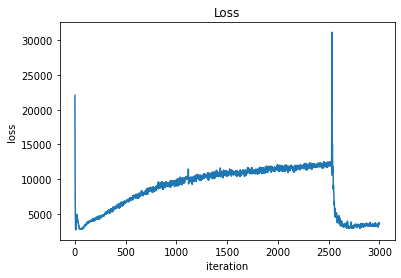

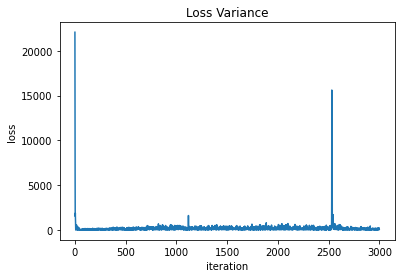

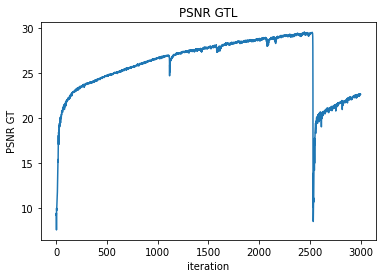

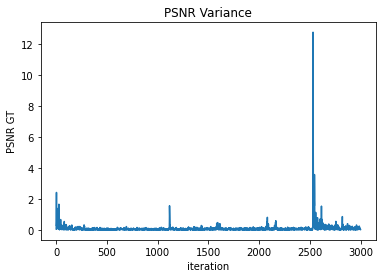

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


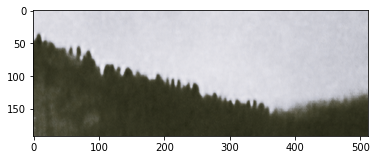

In [13]:
mat_savepath='loss_result/lamda'+str(labda)+'/'+imgname+'/'
losslist = np.asarray(losslist)
np.save(file=mat_savepath+'loss-'+imgname+'-'+'lamda'+str(labda)+'.npy', arr=losslist)
lossabs=np.asarray(lossabs)
np.save(file=mat_savepath+'loss_abs-'+imgname+'-'+'lamda'+str(labda)+'.npy', arr=lossabs)
psnr_gtlist = np.asarray(psnr_gtlist)
np.save(file=mat_savepath+'psnr-'+imgname+'-'+'lamda'+str(labda)+'.npy', arr=psnr_gtlist)
psnr_gtabs=abs(np.asarray(psnr_gtlist)[1:]-np.asarray(psnr_gtlist)[:-1])
np.save(file=mat_savepath+'psnr_abs-'+imgname+'-'+'lamda'+str(labda)+'.npy', arr=psnr_gtabs)

plt.plot(np.arange(len(losslist)),losslist)
plt.title("Loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(mat_savepath+'loss-'+imgname+'-'+'lamda'+str(labda)+'.png')
plt.show()

plt.plot(np.arange(len(lossabs)),lossabs)
plt.title("Loss Variance")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(mat_savepath+'loss_abs-'+imgname+'-'+'lamda'+str(labda)+'.png')
plt.show()

plt.plot(np.arange(len(psnr_gtlist)),psnr_gtlist)
plt.title("PSNR GTL")
plt.xlabel("iteration")
plt.ylabel("PSNR GT")
plt.savefig(mat_savepath+'psnr-'+imgname+'-'+'lamda'+str(labda)+'.png')
plt.show()

plt.plot(np.arange(len(psnr_gtabs)),psnr_gtabs)
plt.title("PSNR Variance")
plt.xlabel("iteration")
plt.ylabel("PSNR GT")
plt.savefig(mat_savepath+'psnr_abs-'+imgname+'-'+'lamda'+str(labda)+'.png')
plt.show()

out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);
#plot_image_grid([out_np,outpre,outafter], factor=5);